In [3]:
import numpy as np
from glob import glob
from PIL import Image
from sklearn import metrics
from skimage.metrics import variation_of_information
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import threading
import os
import json
from PIL.PngImagePlugin import PngInfo

/Users/isaac/miniforge3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def calculate_overlap(r1, r2):
    # intersection
    a = np.count_nonzero(r1 * r2)
    # union
    b = np.count_nonzero(r1 + r2)
    return a/b

def calculate_SC(segmentation, gt):
    N = segmentation.shape[0] * segmentation.shape[1]
    maxcoverings_sum = 0
    for label1 in np.unique(segmentation):
        # region1 is where the segmentation has a specific label
        region1 = (segmentation == label1).astype(int) 
        # |R| is the size of nonzero elements as this the region size
        len_r = np.count_nonzero(region1) 
        max_overlap = 0
        # Calculate max overlap 
        for label2 in np.unique(gt):
            # region2 is where the segmentation has a specific label
            region2 = (gt == label2).astype(int)
            # Calculate overlap
            overlap = calculate_overlap(region1, region2)
            max_overlap = max(max_overlap, overlap)
        maxcoverings_sum += (len_r * max_overlap)
    return (1 / N) * maxcoverings_sum

def calculate_VI(segmentation, gt):
    VI = np.min(variation_of_information(segmentation, gt))
    return VI

def calculate_PRI(segmentation, gt):
    PRI = metrics.adjusted_rand_score(segmentation.flatten(), gt.flatten())
    return PRI

def calculate_mIOU(segmentation, gt):
    gt_array = gt
    miou_for_each_class = []
    label_list = np.unique(gt_array)

    # gt_mask is 0 where gt label is 0 (background) and 1 where gt label is not 0 (foreground)
    gg = np.zeros(gt_array.shape)
    gt_mask = np.where(gt_array > 0, 1, gg)
    # label_list is the list of labels in the input array (range(k))
    label_list = np.unique(gt_array)


    gt_array_1d = gt.reshape((gt.shape[0]*gt.shape[1])) # 1d array of gt labels
    input_array_1d = segmentation.reshape((segmentation.shape[0]*segmentation.shape[1])) # 1d array of input labels

    miou_list = []
    # For each class in range k
    for l in label_list:
        inds = np.where( gt_array_1d == l )[0] # indices of gt where label is l
        pred_labels = input_array_1d[ inds ] # predictions at those indices
        u_pred_labels = np.unique(pred_labels) # unique predictions at those indices
        hists = [ np.sum(pred_labels == u) for u in u_pred_labels ] # frequency of each unique prediction at those indices
        fractions = [ len(inds) + np.sum(input_array_1d == u) - np.sum(pred_labels == u) for u in u_pred_labels ] # (total number of pixels in gt with label l) + (total number of pixels in input with label u) - (total number of pixels in input with label u and gt label l)
        mious = hists / np.array(fractions,dtype='float')
        miou_list.append( np.max(mious) )
        miou_for_each_class.append( np.max(mious) )
        
    mIOU = sum(miou_list) / float(len(miou_list))

    return mIOU

In [7]:
def str_is_num(s):
    return np.array([(char in "0123456789.-") for char in s]).all()

def has_been_evaluated(segmentation):
    conditions1 = np.array([
        "sc" in segmentation.text,
        "vi" in segmentation.text,
        "pri" in segmentation.text,
        "miou" in segmentation.text
    ])
    if not conditions1.all():
        return False
    # conditions2 = np.array([
    #     str_is_num(segmentation.text["sc"]),
    #     str_is_num(segmentation.text["vi"]),
    #     str_is_num(segmentation.text["pri"]),
    #     str_is_num(segmentation.text["miou"])
    # ])
    # if not conditions2.all():
    #     print(segmentation.text["sc"],
    #     segmentation.text["vi"],
    #     segmentation.text["pri"],
    #     segmentation.text["miou"])
    #     return False
    else:
        return True
        
results = {}
def evaluate(method_name):
    print(f"Evaluating {method_name}...")
    with open("../datasets/noise/test_ids.txt", "r") as f:
        noise_segmentation_paths = [f"../results/{method_name}/noise/" + line.strip() + ".png" for line in f.readlines()]
    with open("../datasets/clouds/test_ids.txt", "r") as f:
        cloud_segmentation_paths = [f"../results/{method_name}/clouds/" + line.strip() + ".png" for line in f.readlines()]
    with open("../datasets/texture/test_ids.txt", "r") as f:
        texture_segmentation_paths = [f"../results/{method_name}/texture/" + line.strip() + ".png" for line in f.readlines()]
    # segmentation_times = []
    cloud_scs = []
    cloud_vis = []
    cloud_pris = []
    cloud_mious = []
    print(f"Evaluating {method_name} on clouds dataset (1/3)...")
    for path in cloud_segmentation_paths:
        id = path.split("/")[-1].split(".")[0]
        if not os.path.exists(path):
            cloud_scs.append(0)
            cloud_vis.append(100)
            cloud_pris.append(0)
            cloud_mious.append(0)
            continue
        segmentation = Image.open(path)
        if has_been_evaluated(segmentation):
            sc = float(segmentation.text["sc"])
            vi = float(segmentation.text["vi"])
            pri = float(segmentation.text["pri"])
            miou = float(segmentation.text["miou"])
        else:
            segmentation = np.array(segmentation)
            gt = np.array(Image.open(f"../datasets/clouds/gt/{id}.png"))
            segmentation = torch.from_numpy(segmentation).unsqueeze(0).unsqueeze(0)
            segmentation = torch.nn.functional.interpolate(segmentation, size=gt.shape, mode="nearest").squeeze().numpy()
            sc = calculate_SC(segmentation, gt)
            vi = calculate_VI(segmentation, gt)
            pri = calculate_PRI(segmentation, gt)
            miou = calculate_mIOU(segmentation, gt)
            metadata = PngInfo()
            metadata.add_text("sc", str(sc))
            metadata.add_text("vi", str(vi))
            metadata.add_text("pri", str(pri))
            metadata.add_text("miou", str(miou))
            Image.fromarray(segmentation).save(path, pnginfo=metadata)
        cloud_scs.append(sc)
        cloud_vis.append(vi)
        cloud_pris.append(pri)
        cloud_mious.append(miou)
    noise_scs = {"0.5":[], "1.0":[], "2.0":[], "4.0":[], "8.0":[]}
    noise_vis = {"0.5":[], "1.0":[], "2.0":[], "4.0":[], "8.0":[]}
    noise_pris = {"0.5":[], "1.0":[], "2.0":[], "4.0":[], "8.0":[]}
    noise_mious = {"0.5":[], "1.0":[], "2.0":[], "4.0":[], "8.0":[]}
    print(f"Evaluating {method_name} on noise dataset (2/3)...")
    for path in noise_segmentation_paths:
        id = path.split("/")[-1].split(".")[0]
        noise_level = path.split("/")[-2]
        if not os.path.exists(path):
            noise_scs[noise_level].append(0)
            noise_vis[noise_level].append(100)
            noise_pris[noise_level].append(0)
            noise_mious[noise_level].append(0)
            continue
        segmentation = Image.open(path)
        if has_been_evaluated(segmentation):
            sc = float(segmentation.text["sc"])
            vi = float(segmentation.text["vi"])
            pri = float(segmentation.text["pri"])
            miou = float(segmentation.text["miou"])
        else:
            segmentation = np.array(segmentation)
            gt = np.array(Image.open(f"../datasets/noise/gt/{id}.png").convert("L"))
            segmentation = torch.from_numpy(segmentation).unsqueeze(0).unsqueeze(0)
            segmentation = torch.nn.functional.interpolate(segmentation, size=gt.shape, mode="nearest").squeeze().numpy()
            sc = calculate_SC(segmentation, gt)
            vi = calculate_VI(segmentation, gt)
            pri = calculate_PRI(segmentation, gt)
            miou = calculate_mIOU(segmentation, gt)
            metadata = PngInfo()
            metadata.add_text("sc", str(sc))
            metadata.add_text("vi", str(vi))
            metadata.add_text("pri", str(pri))
            metadata.add_text("miou", str(miou))
            Image.fromarray(segmentation).save(path, pnginfo=metadata)
        noise_scs[noise_level].append(sc)
        noise_vis[noise_level].append(vi)
        noise_pris[noise_level].append(pri)
        noise_mious[noise_level].append(miou)
    texture_scs = []
    texture_vis = []
    texture_pris = []
    texture_mious = []
    print(f"Evaluating {method_name} on texture dataset (3/3)...")
    for path in texture_segmentation_paths:
        id = f'{int(path.split("/")[-1].split(".")[0].split("_")[0]):04d}'
        if not os.path.exists(path):
            texture_scs.append(0)
            texture_vis.append(100)
            texture_pris.append(0)
            texture_mious.append(0)
            continue
        segmentation = Image.open(path)
        if has_been_evaluated(segmentation):
            sc = float(segmentation.text["sc"])
            vi = float(segmentation.text["vi"])
            pri = float(segmentation.text["pri"])
            miou = float(segmentation.text["miou"])
        else:
            segmentation = np.array(segmentation)
            gt = np.array(Image.open(f"../datasets/texture/gt/{id}.png").convert("L"))
            segmentation = torch.from_numpy(segmentation).unsqueeze(0).unsqueeze(0)
            segmentation = torch.nn.functional.interpolate(segmentation, size=gt.shape, mode="nearest").squeeze().numpy()
            sc = calculate_SC(segmentation, gt)
            vi = calculate_VI(segmentation, gt)
            pri = calculate_PRI(segmentation, gt)
            miou = calculate_mIOU(segmentation, gt)
            metadata = PngInfo()
            metadata.add_text("sc", str(sc))
            metadata.add_text("vi", str(vi))
            metadata.add_text("pri", str(pri))
            metadata.add_text("miou", str(miou))
            Image.fromarray(segmentation).save(path, pnginfo=metadata)
        texture_scs.append(sc)
        texture_vis.append(vi)
        texture_pris.append(pri)
        texture_mious.append(miou)
    results_for_method = {
        "clouds": {
            "sc": np.mean(cloud_scs),
            "vi": np.mean(cloud_vis),
            "pri": np.mean(cloud_pris),
            "miou": np.mean(cloud_mious)
        },
        "noise_0.5": {
            "sc": np.mean(noise_scs["0.5"]),
            "vi": np.mean(noise_vis["0.5"]),
            "pri": np.mean(noise_pris["0.5"]),
            "miou": np.mean(noise_mious["0.5"])
        },
        "noise_1.0": {
            "sc": np.mean(noise_scs["1.0"]),
            "vi": np.mean(noise_vis["1.0"]),
            "pri": np.mean(noise_pris["1.0"]),
            "miou": np.mean(noise_mious["1.0"])
        },
        "noise_2.0": {
            "sc": np.mean(noise_scs["2.0"]),
            "vi": np.mean(noise_vis["2.0"]),
            "pri": np.mean(noise_pris["2.0"]),
            "miou": np.mean(noise_mious["2.0"])
        },
        "noise_4.0": {
            "sc": np.mean(noise_scs["4.0"]),
            "vi": np.mean(noise_vis["4.0"]),
            "pri": np.mean(noise_pris["4.0"]),
            "miou": np.mean(noise_mious["4.0"])
        },
        "noise_8.0": {
            "sc": np.mean(noise_scs["8.0"]),
            "vi": np.mean(noise_vis["8.0"]),
            "pri": np.mean(noise_pris["8.0"]),
            "miou": np.mean(noise_mious["8.0"])
        },
        "texture": {
            "sc": np.mean(texture_scs),
            "vi": np.mean(texture_vis),
            "pri": np.mean(texture_pris),
            "miou": np.mean(texture_mious)
        },
        "all": {
            "sc": np.mean(cloud_scs + noise_scs["2.0"] + texture_scs),
            "vi": np.mean(cloud_vis + noise_vis["2.0"] + texture_vis),
            "pri": np.mean(cloud_pris + noise_pris["2.0"] + texture_pris),
            "miou": np.mean(cloud_mious + noise_mious["2.0"] + texture_mious)
        }
    }
    results[method_name] = results_for_method
    print(f"{method_name} evaluation finished")
    return results_for_method


methods = ["DFC", "GNEMS", "DSS", "W-Net"]
# spawn threads
threads = []
for method in methods:
    t = threading.Thread(target=evaluate, args=(method,))
    threads.append(t)
    t.start()
# wait for threads to finish
for i,t in enumerate(threads):
    t.join()

with open("../results/results.json", "w") as f:
    json.dump(results, f, indent=4)
with open("../results/results.json", "r") as f:
    results = json.load(f)


Evaluating DFC...
Evaluating GNEMS...
Evaluating DSS...
Evaluating W-Net...
Evaluating GNEMS on clouds dataset (1/3)...
Evaluating DSS on clouds dataset (1/3)...
Evaluating DFC on clouds dataset (1/3)...
Evaluating W-Net on clouds dataset (1/3)...
Evaluating GNEMS on noise dataset (2/3)...
Evaluating DSS on noise dataset (2/3)...
Evaluating W-Net on noise dataset (2/3)...
Evaluating DFC on noise dataset (2/3)...
Evaluating DSS on texture dataset (3/3)...
Evaluating GNEMS on texture dataset (3/3)...
Evaluating W-Net on texture dataset (3/3)...
DSS evaluation finished
Evaluating DFC on texture dataset (3/3)...
GNEMS evaluation finished
W-Net evaluation finished
DFC evaluation finished


In [8]:
# pretty print results
for task in ["clouds", "texture", "noise_0.5", "noise_1.0", "noise_2.0", "noise_4.0", "noise_8.0", "all"]:
    print(f"Task: {task}")
    print("Method\t\t\tSC\t\tVI\t\tPRI\t\tmIOU")
    for method in results:
        print(f"{method}\t\t{results[method][task]['sc']:.3f}\t\t{results[method][task]['vi']:.3f}\t\t{results[method][task]['pri']:.3f}\t\t{results[method][task]['miou']:.3f}")
    print()

Task: clouds
Method			SC		VI		PRI		mIOU
DSS		0.493		0.710		0.052		0.431
GNEMS		0.667		0.395		0.259		0.582
W-Net		0.600		0.318		0.304		0.591
DFC		0.617		0.443		0.163		0.531

Task: texture
Method			SC		VI		PRI		mIOU
DSS		0.415		0.932		0.034		0.408
GNEMS		0.620		0.510		0.251		0.587
W-Net		0.507		0.597		0.081		0.491
DFC		0.529		0.411		0.047		0.487

Task: noise_0.5
Method			SC		VI		PRI		mIOU
DSS		0.540		0.497		0.082		0.489
GNEMS		0.958		0.133		0.916		0.956
W-Net		0.794		0.054		0.775		0.840
DFC		0.879		0.096		0.735		0.864

Task: noise_1.0
Method			SC		VI		PRI		mIOU
DSS		0.478		0.841		0.088		0.461
GNEMS		0.945		0.167		0.890		0.943
W-Net		0.866		0.141		0.827		0.880
DFC		0.815		0.146		0.590		0.788

Task: noise_2.0
Method			SC		VI		PRI		mIOU
DSS		0.427		0.919		0.046		0.420
GNEMS		0.843		0.372		0.698		0.838
W-Net		0.667		0.418		0.364		0.645
DFC		0.700		0.295		0.345		0.660

Task: noise_4.0
Method			SC		VI		PRI		mIOU
DSS		0.000		100.000		0.000		0.000
GNEMS		0.703		0.600		0.448		0.696
W-Net		0.582		

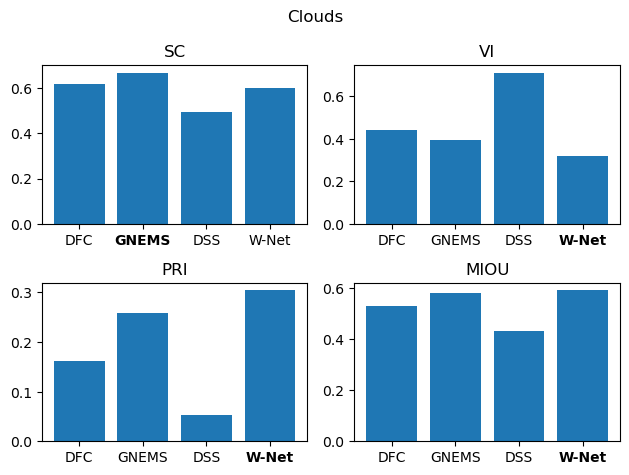

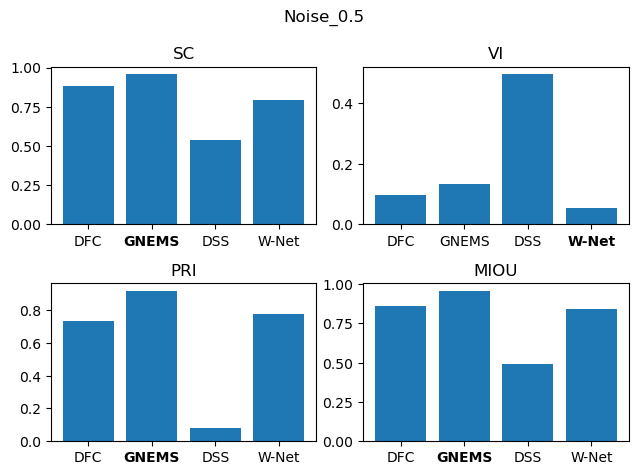

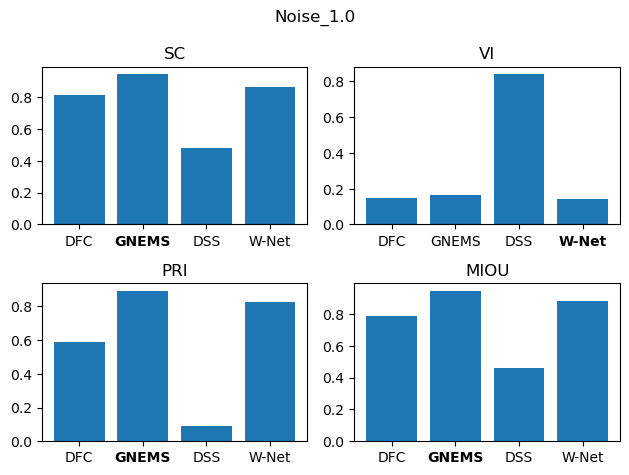

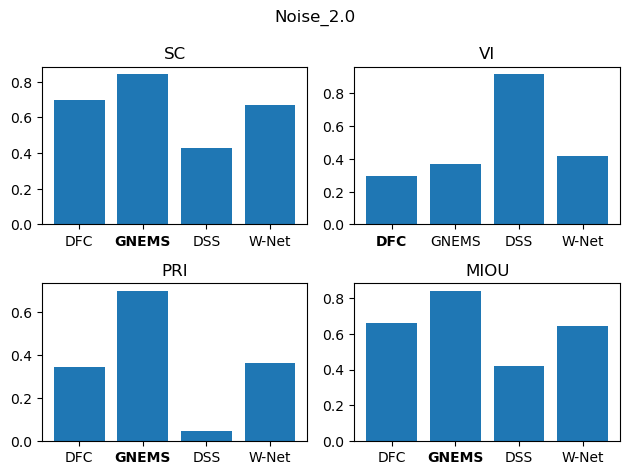

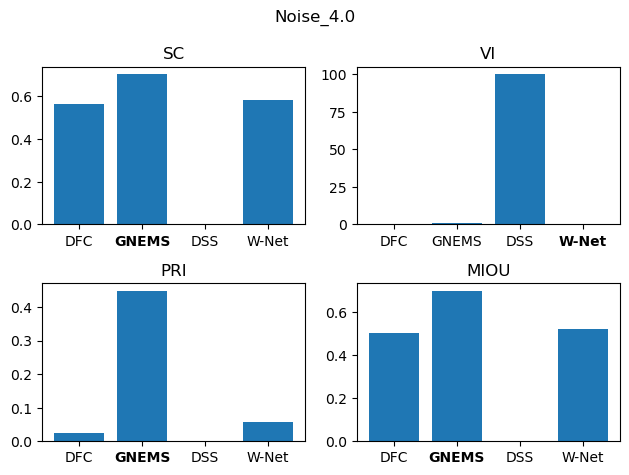

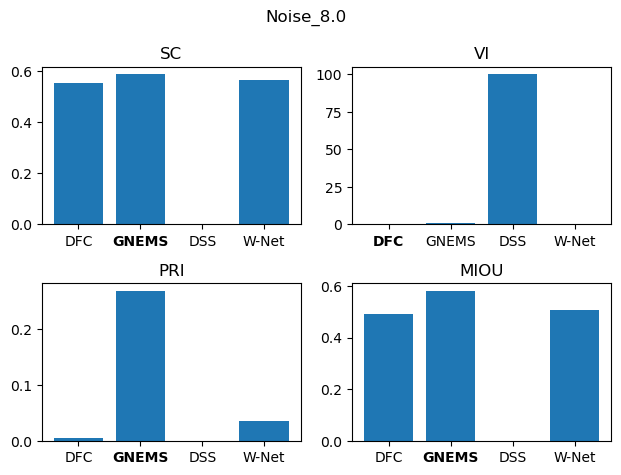

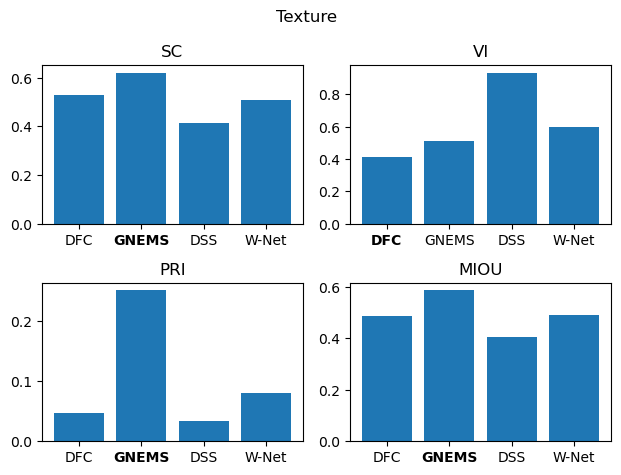

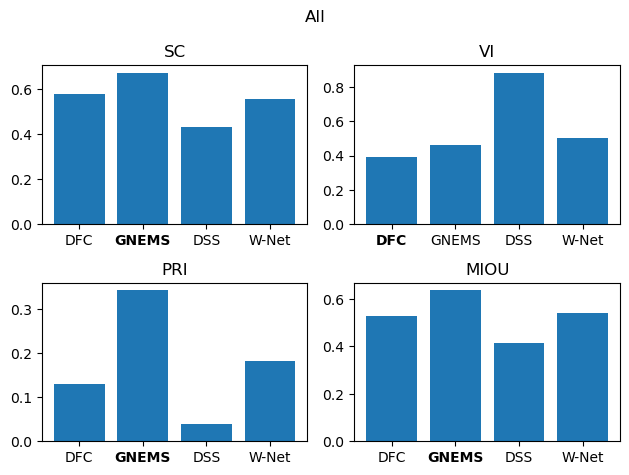

In [43]:
metrics = ["sc", "vi", "pri", "miou"]
tasks = list(results[methods[0]].keys())
for task in tasks:
    fig, axs = plt.subplots(2, 2)
    fig.suptitle(task.capitalize())
    for i,metric in enumerate(metrics):
        values = []
        labels = []
        for method in methods:
            values.append(results[method][task][metric])
            labels.append(method)
        bolding_method = np.argmax if metric.lower() != "vi" else np.argmin
        # labels[bolding_method(values)] = "\\textbf{" + labels[bolding_method(values)] + "}"
        axs[i//2, i%2].bar(labels, values)
        axs[i//2, i%2].set_title(metric.upper())
        axs[i//2, i%2].get_xticklabels()[bolding_method(values)].set_fontweight("bold")
    plt.tight_layout()
    plt.show()
        
        